In [7]:
import numpy as np
import pandas as pd
import os 
import statsmodels as sm
from plotnine import *
np.random.seed(12345)

In [2]:
#we are going to study whether there is evidence of racial discrimination against nonwhites for loan approval
#we also will see the effect of some other variables on loan approval
#white, hrat, obrat, loanprc, unem, male, married, dep, sch, cosign, chist, pubrec, mortlat1, mortlat2, vr
data = pd.read_excel('loanapp.xls', header = None, 
                     names = ['Col' + str(x) for x in range(59)])
#remove missing values
data = data.loc[(data['Col49']!='.') & (data['Col58']!='.') 
                 & (data['Col25']!='.') & (data['Col26']!='.') 
                 & (data['Col56']!='.') & (data['Col38']!='.') 
                 & (data['Col47']!='.') & (data['Col8']!='.')
                 & (data['Col9']!='.') & (data['Col44']!='.')
                 & (data['Col34']!='.') & (data['Col54']!='.')
                 & (data['Col24']!='.') & (data['Col52']!='.')
                 & (data['Col53']!='.') & (data['Col43']!='.')]
#create the estimation dataset of ind vars plus the intercept and dependent variable
data_estimation = pd.DataFrame({'Intercept':[1]*len(data),
                                'approve': data['Col49'], #whether loan was approved or not
                                'white': data['Col58'], #1 if applicant is white
                                'hrat': data['Col25'], #housing expenditure, % of total income
                                'obrat': data['Col26'], #other obligations, % of total income
                                'loanprc': data['Col56'], #loan amount / the total price
                                'unem': data['Col38'], #unemployment rate by industry
                                'male': data['Col47'], #1 if applicant is male
                                'married': data['Col8'], #1 if applicant is married
                                'dep': data['Col9'], #number of dependents 
                                'sch': data['Col44'], #1 if more than 12 years of schooling
                                'cosign': data['Col34'], #1 if there is a cosigner on the loan
                                'chist': data['Col54'], #1 credit history (0 if there are delinquent accounts)
                                'pubrec': data['Col24'], #1 if ever filed for bankruptcy 
                                'mortlat1': data['Col52'], #1 if 1 or 2 late mortgage payments
                                'mortlat2': data['Col53'], #1 if more than 2 late mortgage payments 
                                'vr': data['Col43']})
data_estimation = data_estimation.astype(float)
#summarize data
data_estimation.describe(include = 'all')

,Intercept,approve,white,hrat,obrat,loanprc,unem,male,married,dep,sch,cosign,chist,pubrec,mortlat1,mortlat2,vr
count,1971.0,1971.000000,1971.000000,1971.000000,1971.000000,1971.000000,1971.000000,1971.000000,1971.000000,1971.000000,1971.000000,1971.000000,1971.000000,1971.000000,1971.000000,1971.000000,1971.000000
mean,1.0,0.876205,0.846271,24.800081,32.389797,0.770431,3.888534,0.813293,0.659564,0.771689,0.770167,0.028919,0.836631,0.068493,0.019280,0.010654,0.407915
std,0.0,0.329431,0.360780,7.130267,8.276594,0.189467,2.171818,0.389775,0.473976,1.105423,0.420832,0.167622,0.369796,0.252654,0.137541,0.102695,0.491572
min,1.0,0.000000,0.000000,1.000000,0.000000,0.021053,1.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,1.000000,1.000000,21.000000,28.000000,0.700000,3.100000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,1.0,1.000000,1.000000,25.800000,33.000000,0.800000,3.200000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,1.0,1.000000,1.000000,29.000000,37.000000,0.898906,3.900000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,1.0,1.000000,1.000000,72.000000,95.000000,2.571429,10.600000,1.000000,1.000000,8.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
#run the model
model = sm.discrete.discrete_model.Logit.from_formula('approve ~ white + hrat + obrat + loanprc + unem + male + married + dep + sch + cosign + chist + pubrec + mortlat1 + mortlat2 + vr', 
                                                      data = data_estimation)
results = model.fit(method = 'bfgs', maxiter = 1000)
print(results.summary())
#there is a clear evidence that whites are approved for loans more frequently

Optimization terminated successfully.
         Current function value: 0.304666
         Iterations: 87
         Function evaluations: 90
         Gradient evaluations: 90
                           Logit Regression Results                           
Dep. Variable:                approve   No. Observations:                 1971
Model:                          Logit   Df Residuals:                     1955
Method:                           MLE   Df Model:                           15
Date:                Wed, 05 Feb 2025   Pseudo R-squ.:                  0.1863
Time:                        10:15:08   Log-Likelihood:                -600.50
converged:                       True   LL-Null:                       -737.98
Covariance Type:            nonrobust   LLR p-value:                 8.693e-50
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.8014      0.595      

In [10]:
#let's estimate the same model using build-in likelihood programming functionality
#statsmodels uses object-oriented programming to define likelihood models
#we are going to override the method loglike to define the likelihood model
#loglike computes the log-likelihood
from statsmodels.base.model import GenericLikelihoodModel
class MyLogit(GenericLikelihoodModel):
    def loglike(self, params):
        exog = self.exog
        endog = self.endog
        #logit CDF
        to_insert = 1/(1 + np.exp(-np.dot(exog, params)))
        #calculate total log-likelihood for a given params vector
        vector = endog*np.log(to_insert) + (1 - endog)*np.log(1 - to_insert)
        return sum(vector)
sm_logit_manual = MyLogit.from_formula('approve ~ white + hrat + obrat + loanprc + unem + male + married + dep + sch + cosign + chist + pubrec + mortlat1 + mortlat2 + vr', 
                                        data = data_estimation).fit(method = 'bfgs', maxiter = 1000)
print(sm_logit_manual.summary())

Optimization terminated successfully.
         Current function value: 0.304666
         Iterations: 89
         Function evaluations: 94
         Gradient evaluations: 94
                               MyLogit Results                                
Dep. Variable:                approve   Log-Likelihood:                -600.50
Model:                        MyLogit   AIC:                             1233.
Method:            Maximum Likelihood   BIC:                             1322.
Date:                Wed, 05 Feb 2025                                         
Time:                        10:15:39                                         
No. Observations:                1971                                         
Df Residuals:                    1955                                         
Df Model:                          15                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------

In [11]:
from scipy.stats import norm
class MyProbit(GenericLikelihoodModel):
    def loglike(self, params):
        exog = self.exog
        endog = self.endog
        #logit CDF
        to_insert = norm.cdf(np.dot(exog, params))
        #calculate total log-likelihood for a given params vector
        vector = endog*np.log(to_insert + 10**(-8)) + (1 - endog)*np.log(1 - to_insert + 10**(-8))
        return sum(vector)
sm_probit_manual = MyProbit.from_formula('approve ~ white + hrat + obrat + loanprc + unem + male + married + dep + sch + cosign + chist + pubrec + mortlat1 + mortlat2 + vr', 
                                        data = data_estimation).fit(method = 'bfgs', maxiter = 1000)
print(sm_probit_manual.summary())

Optimization terminated successfully.
         Current function value: 0.304551
         Iterations: 72
         Function evaluations: 81
         Gradient evaluations: 81
                               MyProbit Results                               
Dep. Variable:                approve   Log-Likelihood:                -600.27
Model:                       MyProbit   AIC:                             1233.
Method:            Maximum Likelihood   BIC:                             1322.
Date:                Wed, 05 Feb 2025                                         
Time:                        10:15:59                                         
No. Observations:                1971                                         
Df Residuals:                    1955                                         
Df Model:                          15                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------

In [13]:
#run the model
model = sm.discrete.discrete_model.Probit.from_formula('approve ~ white + hrat + obrat + loanprc + unem + male + married + dep + sch + cosign + chist + pubrec + mortlat1 + mortlat2 + vr', 
                                                      data = data_estimation)
results = model.fit(method = 'bfgs', maxiter = 1000)
print(results.summary())
#there is a clear evidence that whites are approved for loans more frequently

Optimization terminated successfully.
         Current function value: 0.304551
         Iterations: 72
         Function evaluations: 76
         Gradient evaluations: 76
                          Probit Regression Results                           
Dep. Variable:                approve   No. Observations:                 1971
Model:                         Probit   Df Residuals:                     1955
Method:                           MLE   Df Model:                           15
Date:                Wed, 05 Feb 2025   Pseudo R-squ.:                  0.1866
Time:                        10:16:10   Log-Likelihood:                -600.27
converged:                       True   LL-Null:                       -737.98
Covariance Type:            nonrobust   LLR p-value:                 7.014e-50
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0623      0.313      

In [14]:
#run the model
model = sm.discrete.discrete_model.Logit.from_formula('approve ~ white + hrat + obrat + loanprc + unem + male + married + dep + sch + cosign + chist + pubrec + mortlat1 + mortlat2 + vr', 
                                                      data = data_estimation)
results = model.fit(method = 'bfgs', maxiter = 1000)
print(results.summary())
#there is a clear evidence that whites are approved for loans more frequently

Optimization terminated successfully.
         Current function value: 0.304666
         Iterations: 87
         Function evaluations: 90
         Gradient evaluations: 90
                           Logit Regression Results                           
Dep. Variable:                approve   No. Observations:                 1971
Model:                          Logit   Df Residuals:                     1955
Method:                           MLE   Df Model:                           15
Date:                Wed, 05 Feb 2025   Pseudo R-squ.:                  0.1863
Time:                        10:16:18   Log-Likelihood:                -600.50
converged:                       True   LL-Null:                       -737.98
Covariance Type:            nonrobust   LLR p-value:                 8.693e-50
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.8014      0.595      

In [15]:
#model interpretation - discrimination
data_estimation['predict'] = results.predict()
#estimate the mean
data_estimation['mean'] = 0
data_estimation.loc[(data_estimation.white == 0),'mean'] = np.mean(data_estimation.loc[(data_estimation.white == 0),'predict'])
data_estimation.loc[(data_estimation.white == 1),'mean'] = np.mean(data_estimation.loc[(data_estimation.white == 1),'predict'])
#estimate lower bounds
data_estimation['lower_bound'] = 0
data_estimation.loc[(data_estimation.white == 0),'lower_bound'] = np.percentile(data_estimation.loc[(data_estimation.white == 0),'predict'],2.5)
data_estimation.loc[(data_estimation.white == 1),'lower_bound'] = np.percentile(data_estimation.loc[(data_estimation.white == 1),'predict'],2.5)
#estimate upper bounds
data_estimation['upper_bound'] = 0
data_estimation.loc[(data_estimation.white == 0),'upper_bound'] = np.percentile(data_estimation.loc[(data_estimation.white == 0),'predict'],97.5)
data_estimation.loc[(data_estimation.white == 1),'upper_bound'] = np.percentile(data_estimation.loc[(data_estimation.white == 1),'predict'],97.5)

/var/folders/fm/8zsz7ym910313fqhzx92h2940000gp/T/ipykernel_8913/2393699143.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.7029872409761625' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
/var/folders/fm/8zsz7ym910313fqhzx92h2940000gp/T/ipykernel_8913/2393699143.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.1967906430474766' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
/var/folders/fm/8zsz7ym910313fqhzx92h2940000gp/T/ipykernel_8913/2393699143.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.9253821684583704' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.


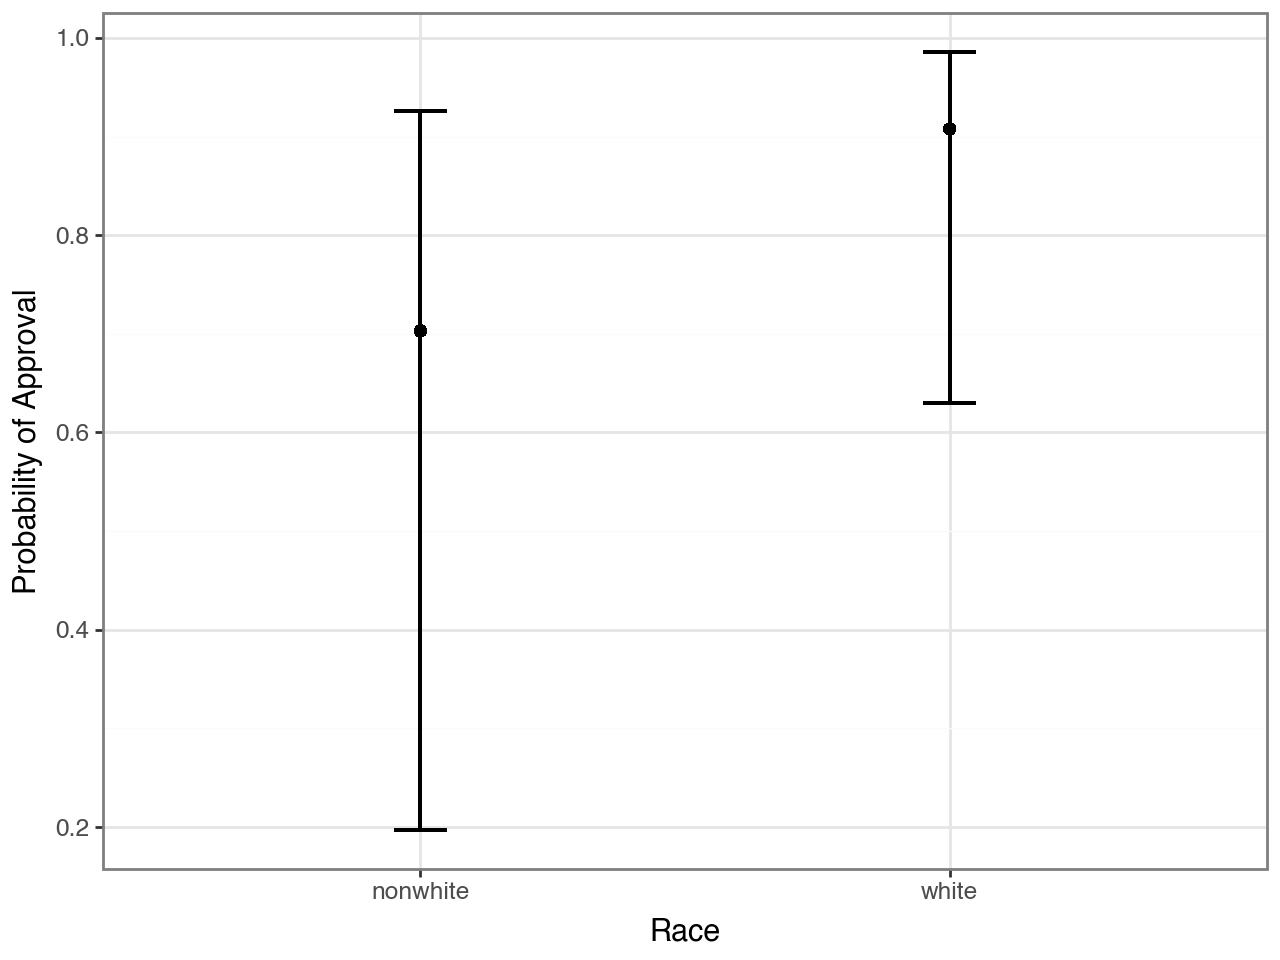

In [17]:
data_estimation['race'] = 'nonwhite'
data_estimation.loc[(data_estimation.white==1), 'race'] = 'white'
plot = (ggplot(data_estimation, aes(x = 'race'))+
        geom_point(aes(y = 'mean'), colour = 'black')+
        geom_errorbar(aes(ymin = 'lower_bound', ymax = 'upper_bound'), width = 0.1)+
        theme_bw()+
        ylab('Probability of Approval')+
        xlab('Race'))
plot

In [18]:
#let's now demonstrate how other interpretation approaches work for loanprc variable
#first, set the independent variables except for loanprc to their means and modes
data_plot = data_estimation.copy()
varlist_binary = ['white', 'unem', 'male', 'married', 'sch', 'cosign', 'chist', 'pubrec', 'mortlat1', 'mortlat2', 'vr']
varlist_continuous = ['hrat', 'obrat', 'dep']
for x in varlist_binary:
    mean = np.mean(data_plot[x])
    if mean>0.5:
        data_plot[x] = 1
    else:
        data_plot[x] = 0
for x in varlist_continuous:
    data_plot[x] = np.mean(data_plot[x])

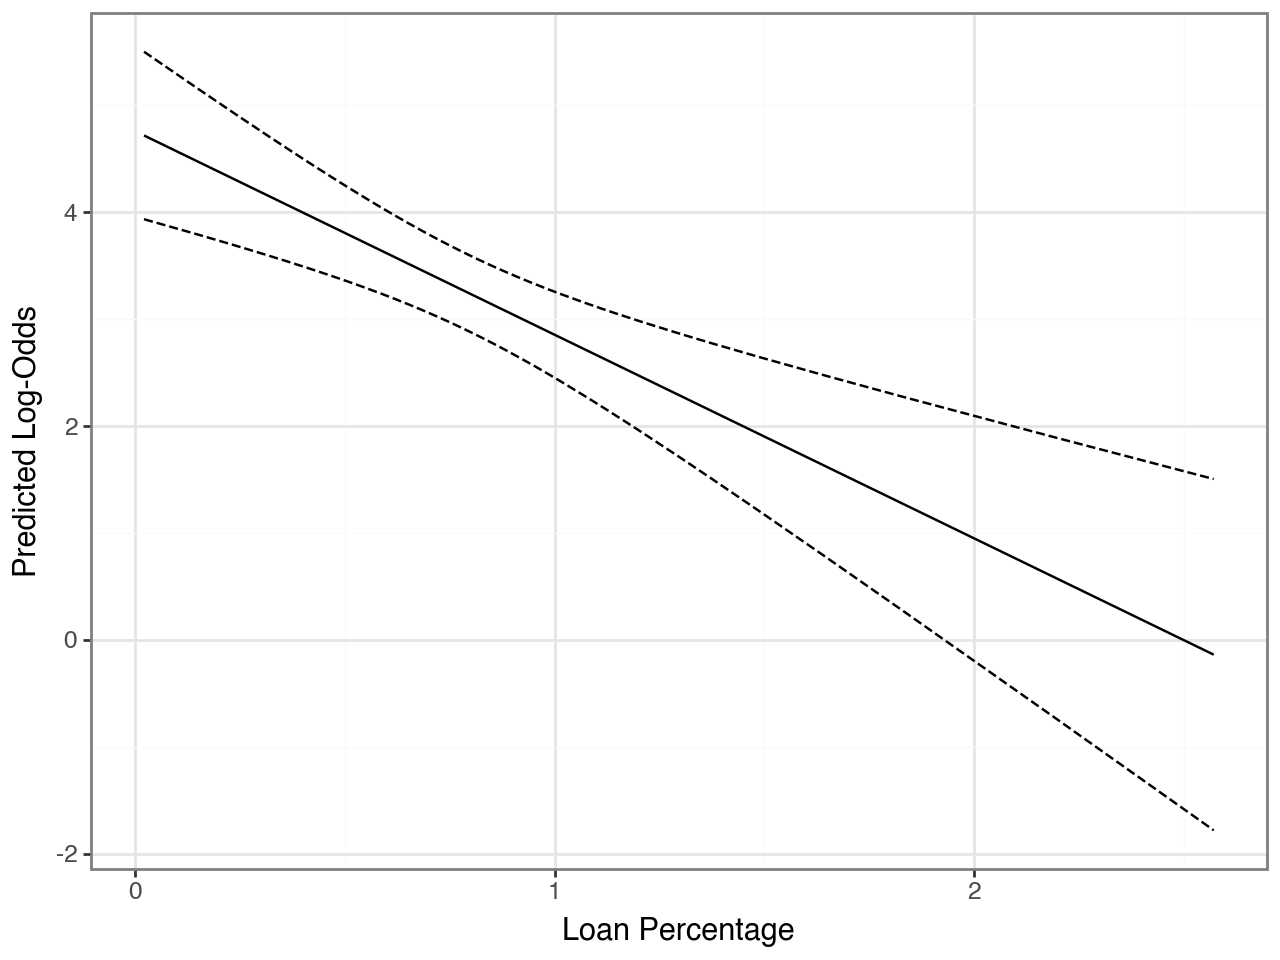

In [20]:
#log-odds interpretation
#compute variance-covariance
variance_covariance = results.cov_params()
data_indvars = data_plot[['Intercept', 'white', 'hrat', 'obrat', 'loanprc', 'unem', 'male', 
                         'married', 'dep', 'sch', 'cosign', 'chist', 'pubrec', 'mortlat1', 'mortlat2', 'vr']]
#calculate predicted log-odds
log_odds = np.dot(data_indvars, results.params)
#compute standard errors
standard_errors = np.dot(data_indvars, variance_covariance)
standard_errors = np.dot(standard_errors, np.transpose(data_indvars))
standard_errors = np.sqrt(np.diag(standard_errors))
#plot the estimates
data_plotting = pd.DataFrame({'Predicted Log-Odds': log_odds,
                              'ub': log_odds + 1.96*standard_errors,
                              'lb': log_odds - 1.96*standard_errors,
                              'Loan Percentage': data_plot['loanprc']})
plot = (ggplot(data_plotting, aes(x = 'Loan Percentage'))+
        geom_line(aes(y = 'Predicted Log-Odds'), linetype = 'solid', colour = 'black')+
        geom_line(aes(y = 'ub'), linetype = 'dashed', colour = 'black') +
        geom_line(aes(y = 'lb'), linetype = 'dashed', colour = 'black') +
        theme_bw()) 
plot

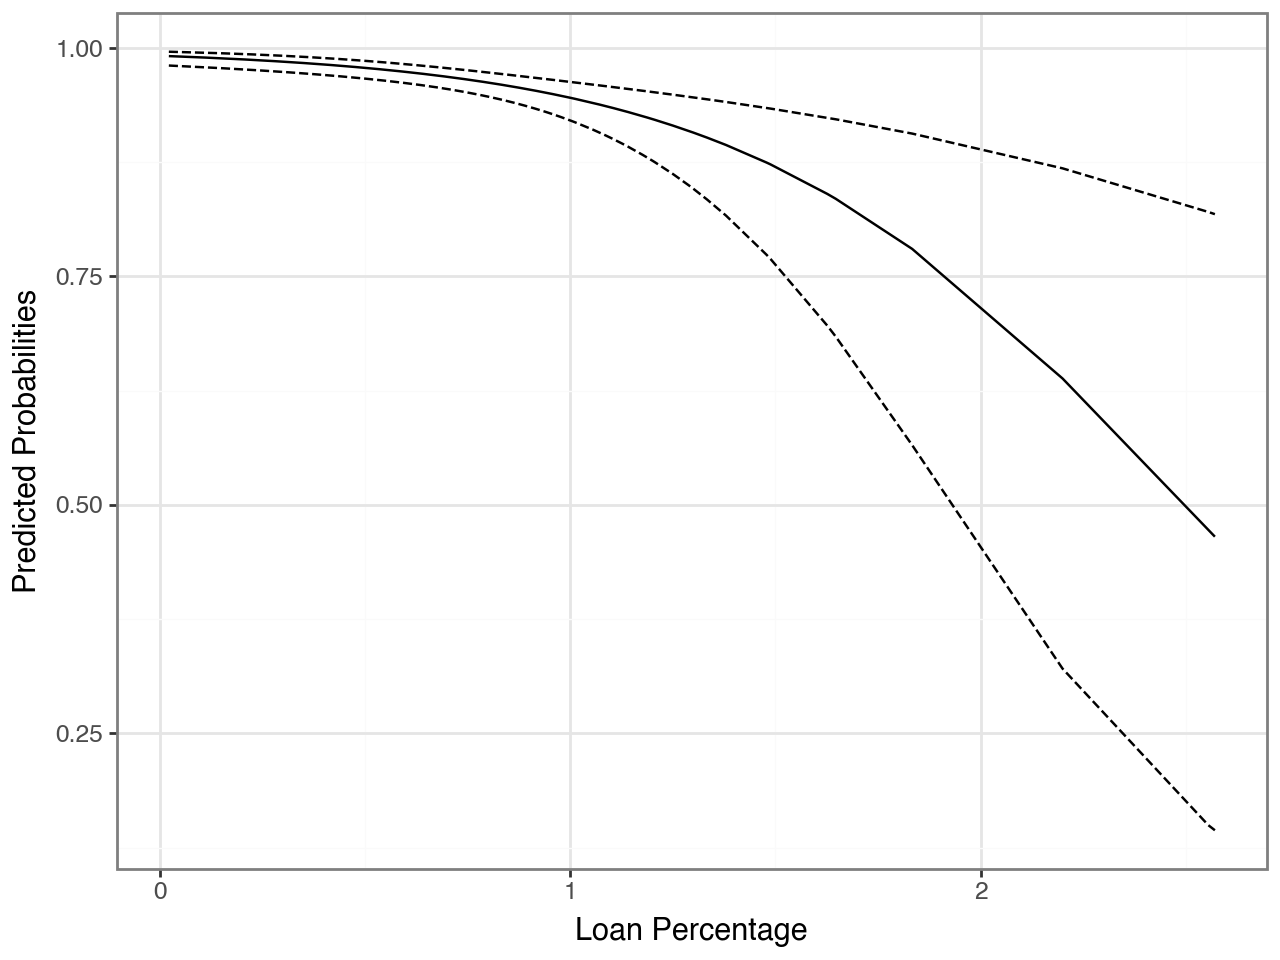

In [21]:
#predicted probabilities - endpoint transformation
#define the logistic CDF function
def logistic_cdf(x):
    return 1/(1 + np.exp(-x))
#apply logistic CDF to Xb, lower and upper bounds
data_plotting = pd.DataFrame({'Predicted Probabilities': logistic_cdf(log_odds),
                              'ub': logistic_cdf(log_odds + 1.96*standard_errors),
                              'lb': logistic_cdf(log_odds - 1.96*standard_errors),
                              'Loan Percentage': data_plot['loanprc']})
plot = (ggplot(data_plotting, aes(x = 'Loan Percentage'))+
        geom_line(aes(y = 'Predicted Probabilities'), linetype = 'solid', colour = 'black')+
        geom_line(aes(y = 'ub'), linetype = 'dashed', colour = 'black') +
        geom_line(aes(y = 'lb'), linetype = 'dashed', colour = 'black') +
        theme_bw()) 
plot

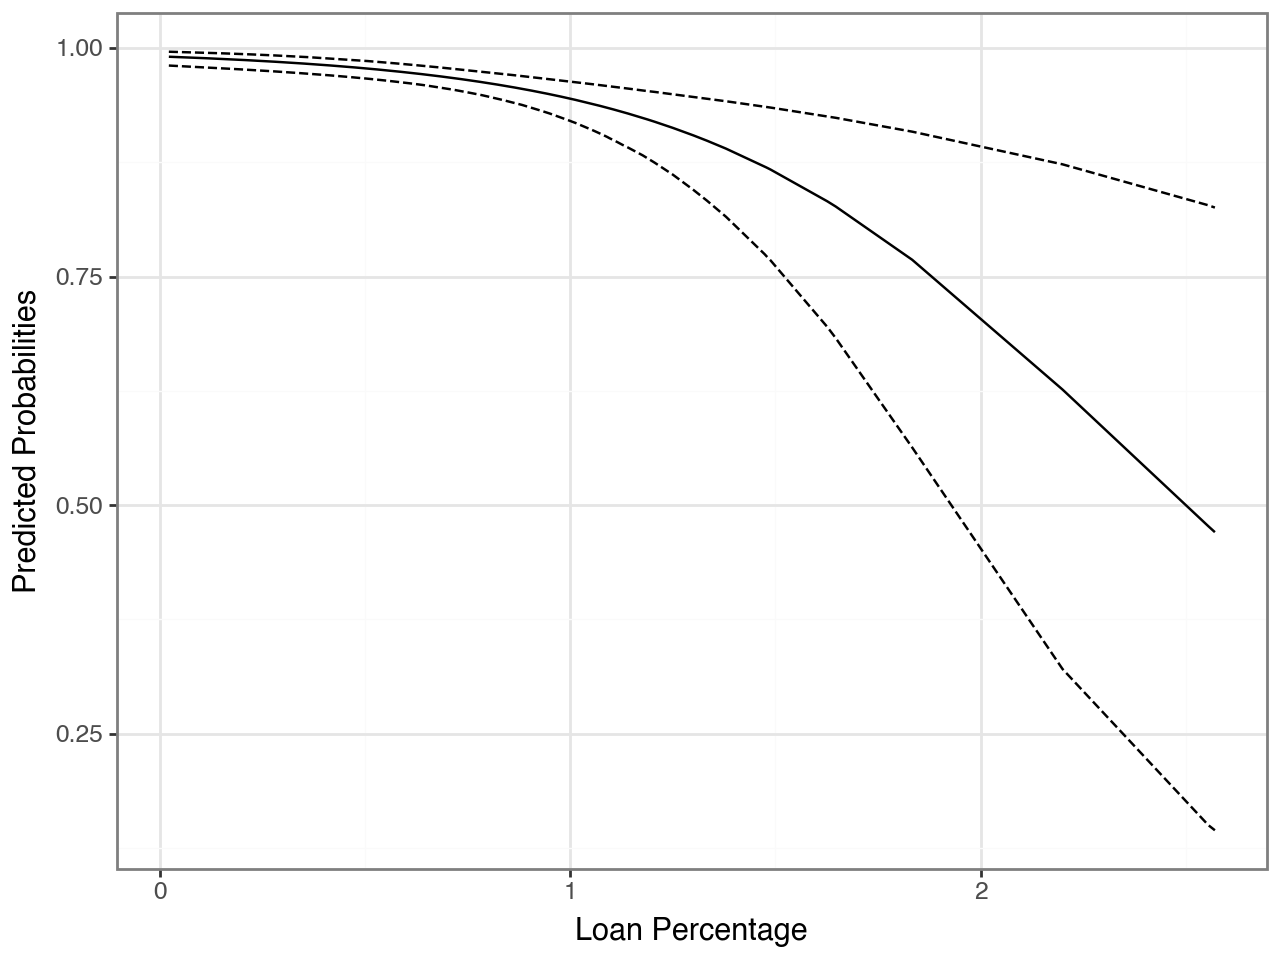

In [22]:
#CLARIFY alrogithm 
sample_normal = np.random.multivariate_normal(results.params, variance_covariance, size = 10000)
#compute the matrix
matrix_values = logistic_cdf(np.dot(data_indvars, np.transpose(sample_normal)))
#calculate means, 2.5 and 97.5 percentiles
means = np.mean(matrix_values, axis = 1)
lb = np.percentile(matrix_values, q = 2.5, axis = 1)
ub = np.percentile(matrix_values, q = 97.5, axis = 1)
#plot
data_plotting = pd.DataFrame({'Predicted Probabilities': means,
                              'ub': ub,
                              'lb': lb,
                              'Loan Percentage': data_plot['loanprc']})
plot = (ggplot(data_plotting, aes(x = 'Loan Percentage'))+
        geom_line(aes(y = 'Predicted Probabilities'), linetype = 'solid', colour = 'black')+
        geom_line(aes(y = 'ub'), linetype = 'dashed', colour = 'black') +
        geom_line(aes(y = 'lb'), linetype = 'dashed', colour = 'black') +
        theme_bw()) 
plot

In [23]:
#different approaches to uncertainty may lead to different interpretations
data_plot = data_estimation.copy()
varlist_binary = ['unem', 'male', 'married', 'sch', 'cosign', 'chist', 'pubrec', 'mortlat1', 'mortlat2', 'vr']
varlist_continuous = ['hrat', 'obrat', 'dep', 'loanprc']
for x in varlist_binary:
    mean = np.mean(data_plot[x])
    if mean>0.5:
        data_plot[x] = 1
    else:
        data_plot[x] = 0
for x in varlist_continuous:
    data_plot[x] = np.mean(data_plot[x])
data_indvars = data_plot[['Intercept', 'white', 'hrat', 'obrat', 'loanprc', 'unem', 'male', 
                         'married', 'dep', 'sch', 'cosign', 'chist', 'pubrec', 'mortlat1', 'mortlat2', 'vr']]

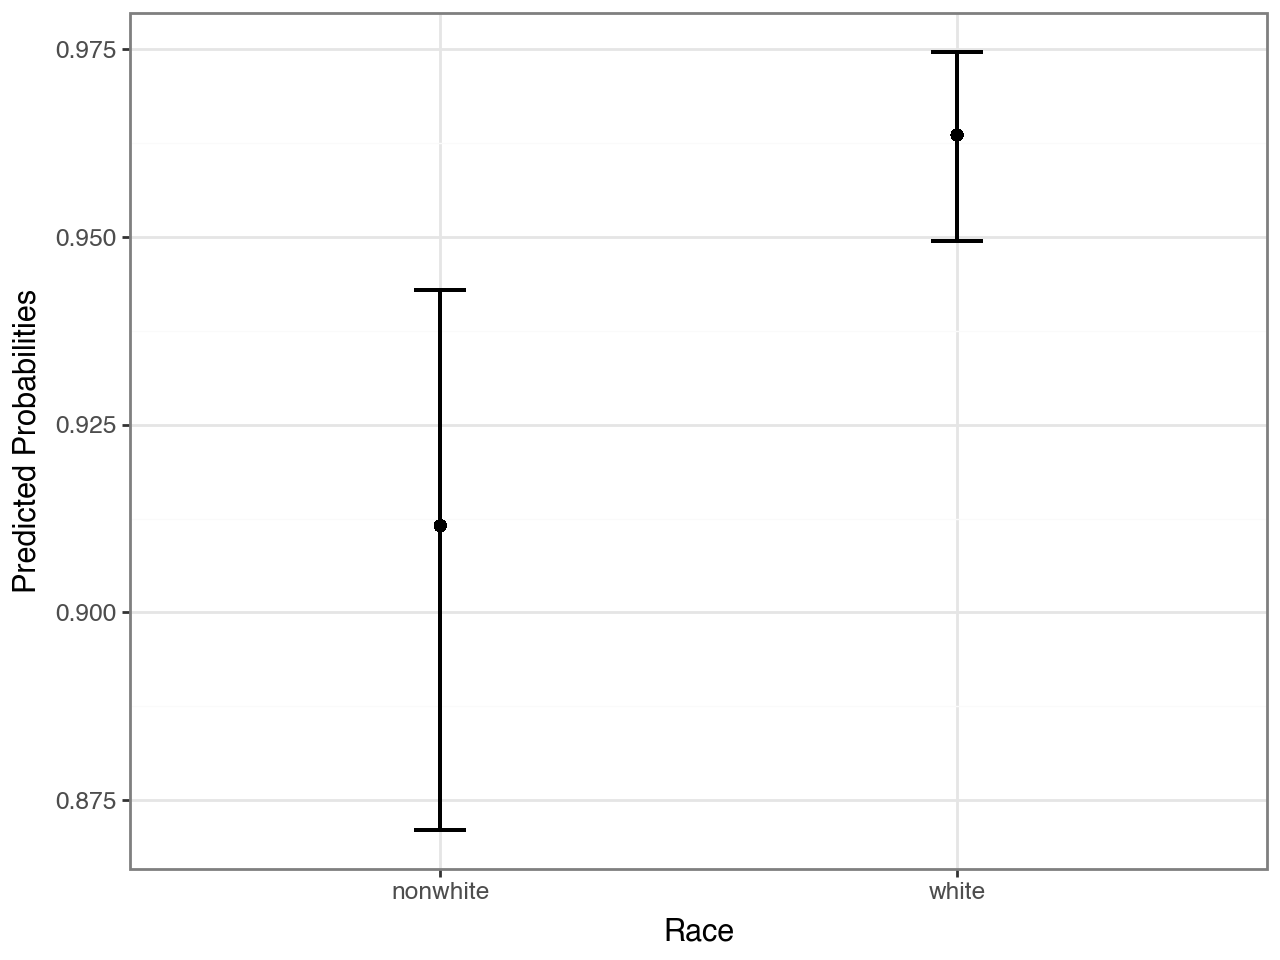

In [25]:
#CLARIFY alrogithm 
sample_normal = np.random.multivariate_normal(results.params, variance_covariance, size = 10000)
#compute the matrix
matrix_values = logistic_cdf(np.dot(data_indvars, np.transpose(sample_normal)))
#calculate means, 2.5 and 97.5 percentiles
means = np.mean(matrix_values, axis = 1)
lb = np.percentile(matrix_values, q = 2.5, axis = 1)
ub = np.percentile(matrix_values, q = 97.5, axis = 1)
#plot
data_plotting = pd.DataFrame({'Predicted Probabilities': means,
                              'ub': ub,
                              'lb': lb,
                              'Race': data_plot['race']})
plot = (ggplot(data_plotting, aes(x = 'Race'))+
        geom_point(aes(y = 'Predicted Probabilities'), colour = 'black')+
        geom_errorbar(aes(ymin = 'lb', ymax = 'ub'), width = 0.1)+
        theme_bw()) 
plot
#here, you can see that confidence intervals do not overlap

## Problem 6

In [36]:
#generate artificial data for demonstration
X_1 = np.random.normal(0,1,size=1000)
X_2 = np.random.normal(3,2,size=1000)
X_3 = np.random.poisson(5,size=1000)
y = 3 + 1.5*X_1 + 3.5*X_2 - 3*X_3 + np.random.logistic(0,1,size=1000)
Y = (y>0)*1
data_estimation = pd.DataFrame({'Intercept':[1]*1000,
                                'X_1': X_1,
                                'X_2': X_2,
                                'X_3': X_3,
                                'Y': Y})

In [37]:
#estimate Logit with statsmodels
model = sm.discrete.discrete_model.Logit.from_formula('Y ~ X_1 + X_2 + X_3', data = data_estimation)
results = model.fit(method = 'bfgs')
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.118369
         Iterations: 29
         Function evaluations: 31
         Gradient evaluations: 31
                           Logit Regression Results                           
Dep. Variable:                      Y   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      996
Method:                           MLE   Df Model:                            3
Date:                Mon, 10 Apr 2023   Pseudo R-squ.:                  0.8279
Time:                        17:12:20   Log-Likelihood:                -118.37
converged:                       True   LL-Null:                       -687.73
Covariance Type:            nonrobust   LLR p-value:                1.447e-246
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.8244      0.634      

In [38]:
#confirm that standard errors are obtained by inverting the negative hessian, taking the diagonal of this inverse
#and then taking square root
hessian = model.hessian(results.params)
np.sqrt(np.diag(np.linalg.inv(-hessian)))

array([0.63412863, 0.22044518, 0.34193128, 0.31327798])

In [39]:
#obtain the same estimates using MyLogit function defined above
sm_logit_manual = MyLogit.from_formula('Y ~ X_1 + X_2 + X_3', data = data_estimation).fit(method = 'bfgs')
print(sm_logit_manual.summary())

Optimization terminated successfully.
         Current function value: 0.118369
         Iterations: 29
         Function evaluations: 31
         Gradient evaluations: 31
                               MyLogit Results                                
Dep. Variable:                      Y   Log-Likelihood:                -118.37
Model:                        MyLogit   AIC:                             244.7
Method:            Maximum Likelihood   BIC:                             264.4
Date:                Mon, 10 Apr 2023                                         
Time:                        17:13:18                                         
No. Observations:                1000                                         
Df Residuals:                     996                                         
Df Model:                           3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------

In [40]:
#numeric optimization for Logit regression -- using minimize function from scipy library
from scipy.optimize import minimize
def likelihood_b(p, dataset, dv):
    matrix_score = np.exp(-np.dot(dataset, p))
    logit_transform = 1/(1 + matrix_score)
    vector = dv*np.log(logit_transform) + (1 - dv)*np.log(1 - logit_transform)
    return -sum(vector)
def gradient_b(p, dataset, dv):
    matrix_score = np.exp(-np.dot(dataset, p))
    first = dv*np.divide(matrix_score, 1 + matrix_score)
    second = (1 - dv)*(1/(1 + matrix_score))
    gradient = []
    for x in range(len(p)):
        first_element = np.dot(first, dataset.iloc[0:,x])
        second_element = np.dot(second,dataset.iloc[0:,x])
        gradient += [-(first_element - second_element)]
    return gradient
optim_logit = minimize(likelihood_b, x0 = [0,0,0,0], method = 'BFGS', jac = gradient_b,
                       args = (data_estimation[['Intercept', 'X_1', 'X_2', 'X_3']], Y),
                       options = {'maxiter': 1000})
print(optim_logit)

      fun: 118.36932328344845
 hess_inv: array([[ 0.37502849,  0.04523122,  0.09537784, -0.14157929],
       [ 0.04523122,  0.04713546,  0.04958695, -0.04367802],
       [ 0.09537784,  0.04958695,  0.10896122, -0.09344034],
       [-0.14157929, -0.04367802, -0.09344034,  0.09352046]])
      jac: array([ 6.18429243e-06, -1.09191756e-05,  1.36223205e-05,  1.74559173e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 65
      nit: 28
     njev: 55
   status: 2
  success: False
        x: array([ 3.82464231,  1.71229669,  3.59183345, -3.27028003])


In [41]:
np.sqrt(np.diag(optim_logit.hess_inv))

array([0.6123957 , 0.21710702, 0.33009275, 0.30581115])

In [42]:
#try with the real data
data_estimation = pd.DataFrame({'Intercept':[1]*len(data),
                                'approve': data['Col49'], #whether loan was approved or not
                                'white': data['Col58'], #1 if applicant is white
                                'hrat': data['Col25'], #housing expenditure, % of total income
                                'obrat': data['Col26'], #other obligations, % of total income
                                'loanprc': data['Col56'], #loan amount / the total price
                                'unem': data['Col38'], #unemployment rate by industry
                                'male': data['Col47'], #1 if applicant is male
                                'married': data['Col8'], #1 if applicant is married
                                'dep': data['Col9'], #number of dependents 
                                'sch': data['Col44'], #1 if more than 12 years of schooling
                                'cosign': data['Col34'], #1 if there is a cosigner on the loan
                                'chist': data['Col54'], #1 credit history (0 if there are delinquent accounts)
                                'pubrec': data['Col24'], #1 if ever filed for bankruptcy 
                                'mortlat1': data['Col52'], #1 if 1 or 2 late mortgage payments
                                'mortlat2': data['Col53'], #1 if more than 2 late mortgage payments 
                                'vr': data['Col43']})
data_estimation = data_estimation.astype(float)
model = sm.discrete.discrete_model.Logit.from_formula('approve ~ white + hrat + obrat + loanprc + unem + male + married + dep + sch + cosign + chist + pubrec + mortlat1 + mortlat2 + vr', 
                                                      data = data_estimation)
results = model.fit(method = 'bfgs', maxiter = 1000)
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.304666
         Iterations: 87
         Function evaluations: 90
         Gradient evaluations: 90
                           Logit Regression Results                           
Dep. Variable:                approve   No. Observations:                 1971
Model:                          Logit   Df Residuals:                     1955
Method:                           MLE   Df Model:                           15
Date:                Mon, 10 Apr 2023   Pseudo R-squ.:                  0.1863
Time:                        17:17:06   Log-Likelihood:                -600.50
converged:                       True   LL-Null:                       -737.98
Covariance Type:            nonrobust   LLR p-value:                 8.693e-50
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.8014      0.595      

In [45]:
optim_logit = minimize(likelihood_b, x0 = [0.15]*16, method = 'BFGS', jac = gradient_b,
                       args = (data_estimation[['Intercept', 'white', 'hrat', 'obrat', 'loanprc',
                                                'unem', 'male', 'married', 'dep', 'sch', 'cosign', 
                                                'chist', 'pubrec', 'mortlat1', 'mortlat2', 'vr']], 
                              data_estimation['approve']),
                       options = {'maxiter': 3000})
print(optim_logit)

      fun: 600.4961568463244
 hess_inv: array([[ 3.53304357e-01, -2.62784446e-02, -1.15478419e-03,
        -1.86702063e-03, -1.73574265e-01, -3.44990556e-03,
        -2.65161812e-02, -1.28439772e-02, -3.13037582e-03,
        -3.37911811e-02, -1.65694959e-02, -1.61499164e-02,
        -1.05632848e-02, -2.19957923e-03, -1.34279645e-02,
        -1.26989481e-02],
       [-2.62784446e-02,  3.10623894e-02, -1.71469083e-05,
         1.09504175e-05,  1.02800942e-02, -3.23415863e-04,
        -3.30293028e-03,  5.36278875e-04,  1.25530113e-03,
        -2.94362186e-03,  2.19396522e-03, -1.83704208e-03,
         2.56026939e-03,  1.84391694e-03,  6.42139083e-04,
         1.75666026e-03],
       [-1.15478419e-03, -1.71469083e-05,  1.73313918e-04,
        -9.72115982e-05, -2.03782512e-04,  1.14603253e-05,
         2.65578888e-04, -7.42169938e-06, -4.07127006e-05,
         6.87019204e-05,  4.40996496e-04, -8.25228598e-05,
         2.03934790e-05,  6.84740276e-04,  2.97560188e-04,
        -1.42537432e-05

<ipython-input-40-05b9286b07d1>:6: RuntimeWarning: divide by zero encountered in log


In [46]:
np.sqrt(np.diag(optim_logit.hess_inv))

array([0.59439411, 0.17624525, 0.01316487, 0.01170984, 0.46320862,
       0.0327168 , 0.20839614, 0.17742876, 0.07195545, 0.17761674,
       0.44508956, 0.17242815, 0.21872585, 0.46205594, 0.56568086,
       0.1545982 ])